<a href="https://colab.research.google.com/github/FelixMarschall/Logbook-ProcessDiscovery/blob/main/approach_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Discovery on the Home Assistant logbook 

In [2]:
import pandas as pd
import pm4py
import datetime

In [4]:
data = pd.read_feather("logbook.feather")

## Data preparation

Filter "useless" information

In [ ]:
data = data.drop(["icon","domain","message","context_user_id", "context_domain", "context_service"], axis=1)

In [ ]:
data = data[data.state != "unavailable"]

In [ ]:
data.when = pd.to_datetime(data.when)
data = data.set_index("when")

In [ ]:
# create additional column, weekday and daytime
data["weekday"]= data.index.day_name()
data["case_id_day"] = data.index.strftime('%Y-%B-%d')

View one period per day

In [ ]:
data = data.between_time('4:00', '9:00')

Set overall timespan

In [ ]:
# filter on data
filtered_df = data.loc[(data.index >= '2023-03-20')
                     & (data.index < '2023-04-01')]

Choose weekdays

In [ ]:
weekdays = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday'
    #"Saturday",
    #"Sunday"
]

In [ ]:
filtered_df = filtered_df[filtered_df["weekday"].isin(weekdays)]

Choose Home Assistant entities by ID

In [ ]:
take_entities = [
    'automation.ios_flurlicht_toggle',
    'automation.ios_kleinekuchenlampe',
    'automation.ios_felixpc',
    'automation.neue_automatisierung',
    'automation.kuchenlampe_aus',
    'automation.kleine_kuchenlampe_an_mitternacht',
    'automation.wohnungstur_nachtlicht',
    'automation.kleine_kuchenlampe_an',
    'automation.felix_pc_aus',
    'binary_sensor.wohnungstur_contact',
    'binary_sensor.bewegungsmelder_bad_occupancy',
    'binary_sensor.bewegungsmelder_klo_occupancy',
    'binary_sensor.bewegungsmelder_kuche_occupancy',
    'binary_sensor.toaster',
    'binary_sensor.wasserkocher',
    'light.flutlichtlampe',
    'switch.kleinelampe',
    'switch.felix_pc'
    ]

In [ ]:
filtered_df = filtered_df[filtered_df["entity_id"].isin(take_entities)]

Transform table for PM4Py

In [ ]:
filtered_df = filtered_df.reset_index()

In [ ]:
mining_data = filtered_df.rename(columns={
    'entity_id':'concept:name',
    'when':'time:timestamp',
    #'weekday':'case:concept:name'
    'case_id_day':'case:concept:name'
    })

In [ ]:
mining_data

,time:timestamp,name,state,concept:name,context_event_type,source,context_id,context_name,context_message,context_source,context_entity_id,context_entity_id_name,context_state,weekday,case:concept:name
0,2023-03-20 04:01:12.653001+00:00,Bewegungsmelder Küche occupancy,off,binary_sensor.bewegungsmelder_kuche_occupancy,None,None,None,None,None,None,None,None,None,Monday,2023-March-20
1,2023-03-20 04:01:18.888421+00:00,Bewegungsmelder Küche occupancy,on,binary_sensor.bewegungsmelder_kuche_occupancy,None,None,None,None,None,None,None,None,None,Monday,2023-March-20
2,2023-03-20 04:05:36.969233+00:00,Bewegungsmelder Küche occupancy,off,binary_sensor.bewegungsmelder_kuche_occupancy,None,None,None,None,None,None,None,None,None,Monday,2023-March-20
3,2023-03-20 04:06:12.130641+00:00,Bewegungsmelder Küche occupancy,on,binary_sensor.bewegungsmelder_kuche_occupancy,None,None,None,None,None,None,None,None,None,Monday,2023-March-20
4,2023-03-20 04:06:31.812429+00:00,Bewegungsmelder Klo occupancy,on,binary_sensor.bewegungsmelder_klo_occupancy,None,None,None,None,None,None,None,None,None,Monday,2023-March-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,2023-03-31 08:44:42.207045+00:00,Toaster,off,binary_sensor.toaster,None,None,None,None,None,None,None,None,None,Friday,2023-March-31
1068,2023-03-31 08:51:02.287404+00:00,Bewegungsmelder Bad occupancy,off,binary_sensor.bewegungsmelder_bad_occupancy,None,None,None,None,None,None,None,None,None,Friday,2023-March-31
1069,2023-03-31 08:51:38.368456+00:00,Bewegungsmelder Bad occupancy,on,binary_sensor.bewegungsmelder_bad_occupancy,None,None,None,None,None,None,None,None,None,Friday,2023-March-31
1070,2023-03-31 08:54:15.603665+00:00,Bewegungsmelder Bad occupancy,off,binary_sensor.bewegungsmelder_bad_occupancy,None,None,None,None,None,None,None,None,None,Friday,2023-March-31


## Process Mining


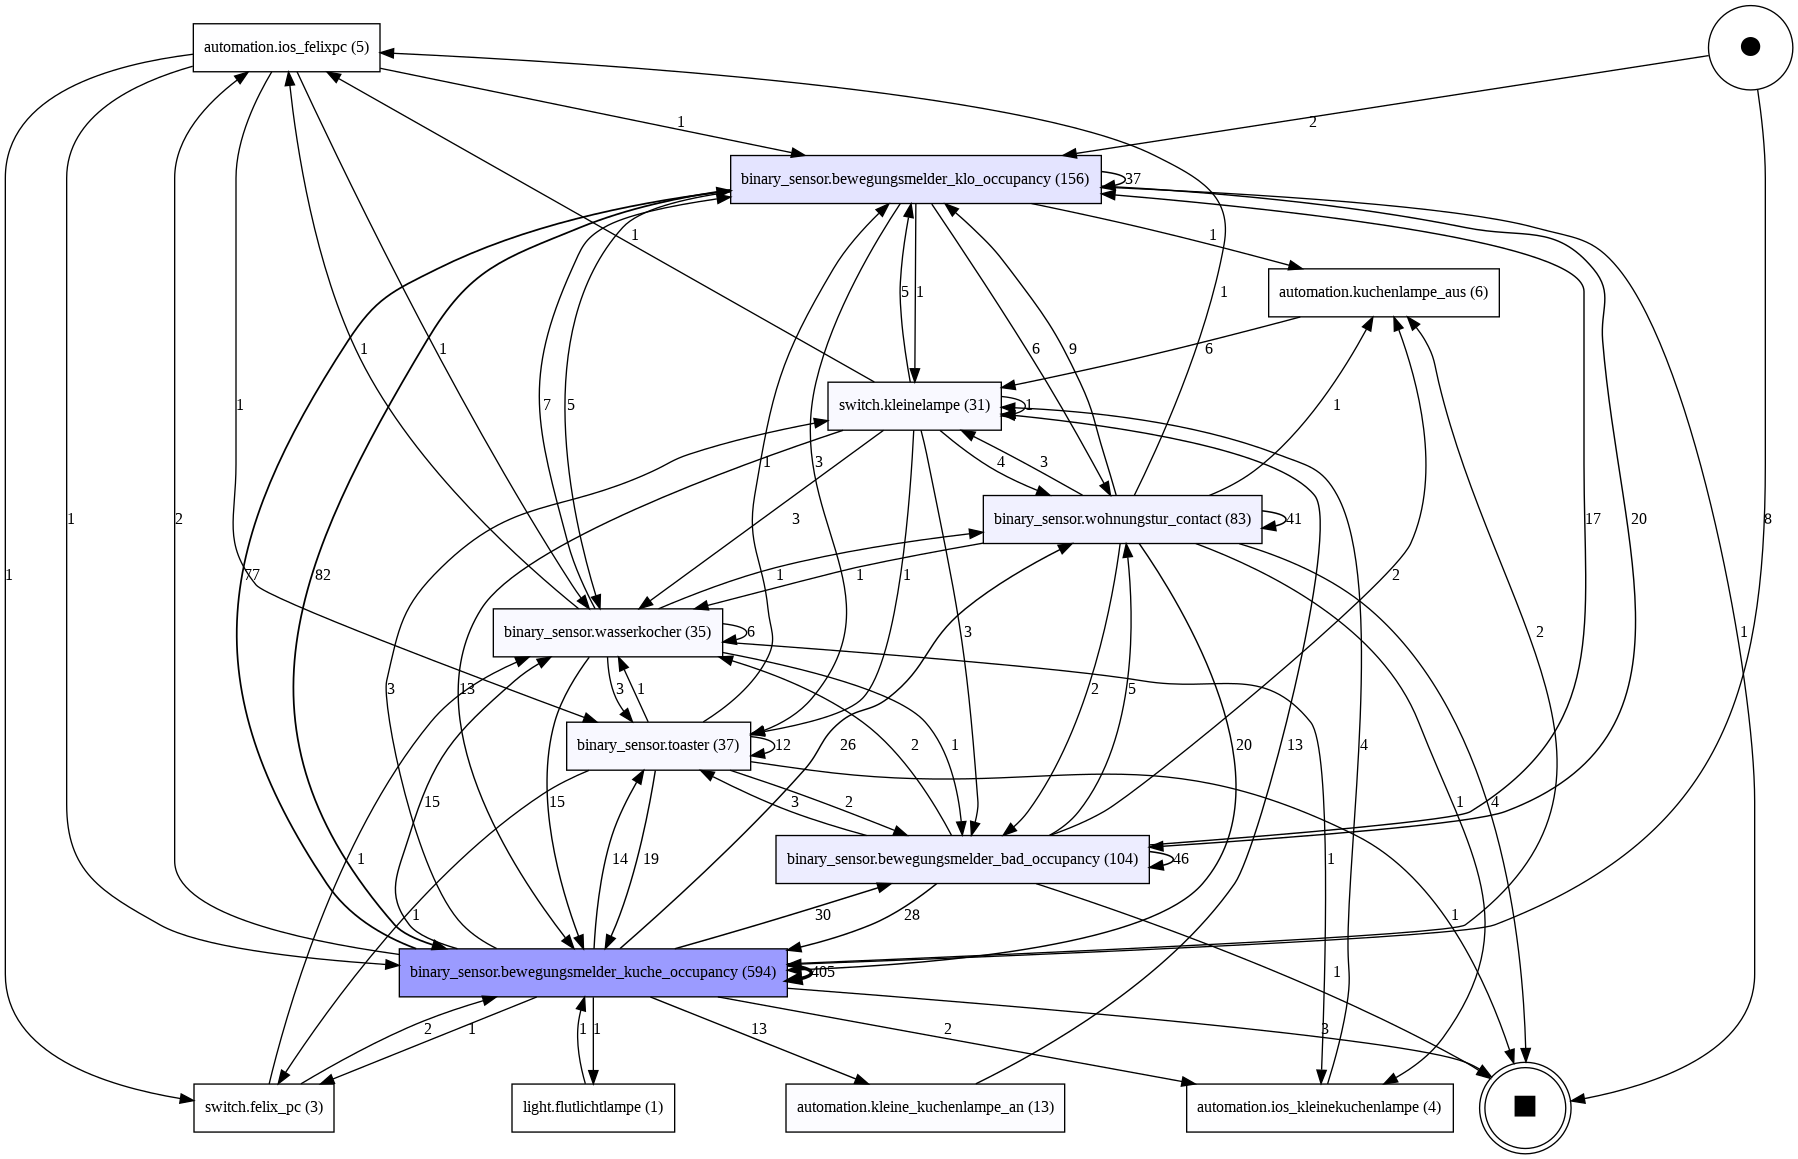

In [ ]:
dfg, sa, ea = pm4py.discover_dfg(mining_data)
pm4py.vis.view_dfg(dfg, sa, ea)


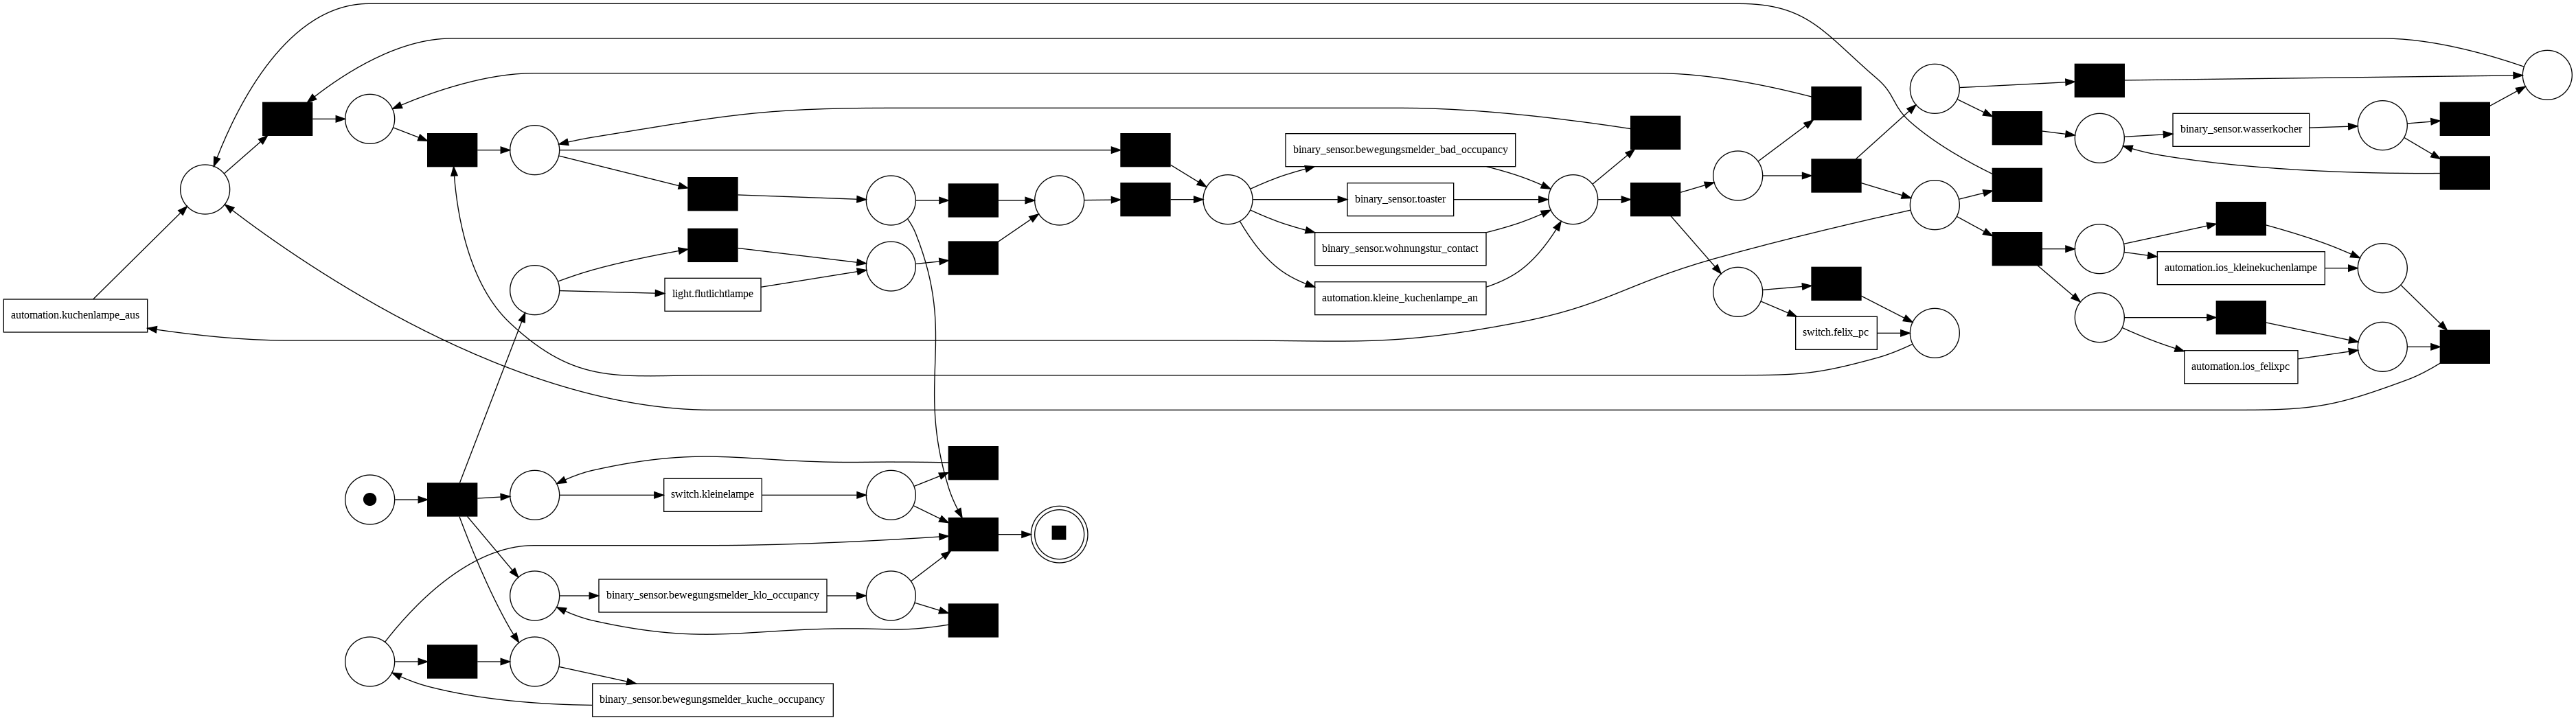

In [ ]:
dfg, sa, ea = pm4py.discover_petri_net_inductive(mining_data)
pm4py.vis.view_petri_net(dfg, sa, ea)

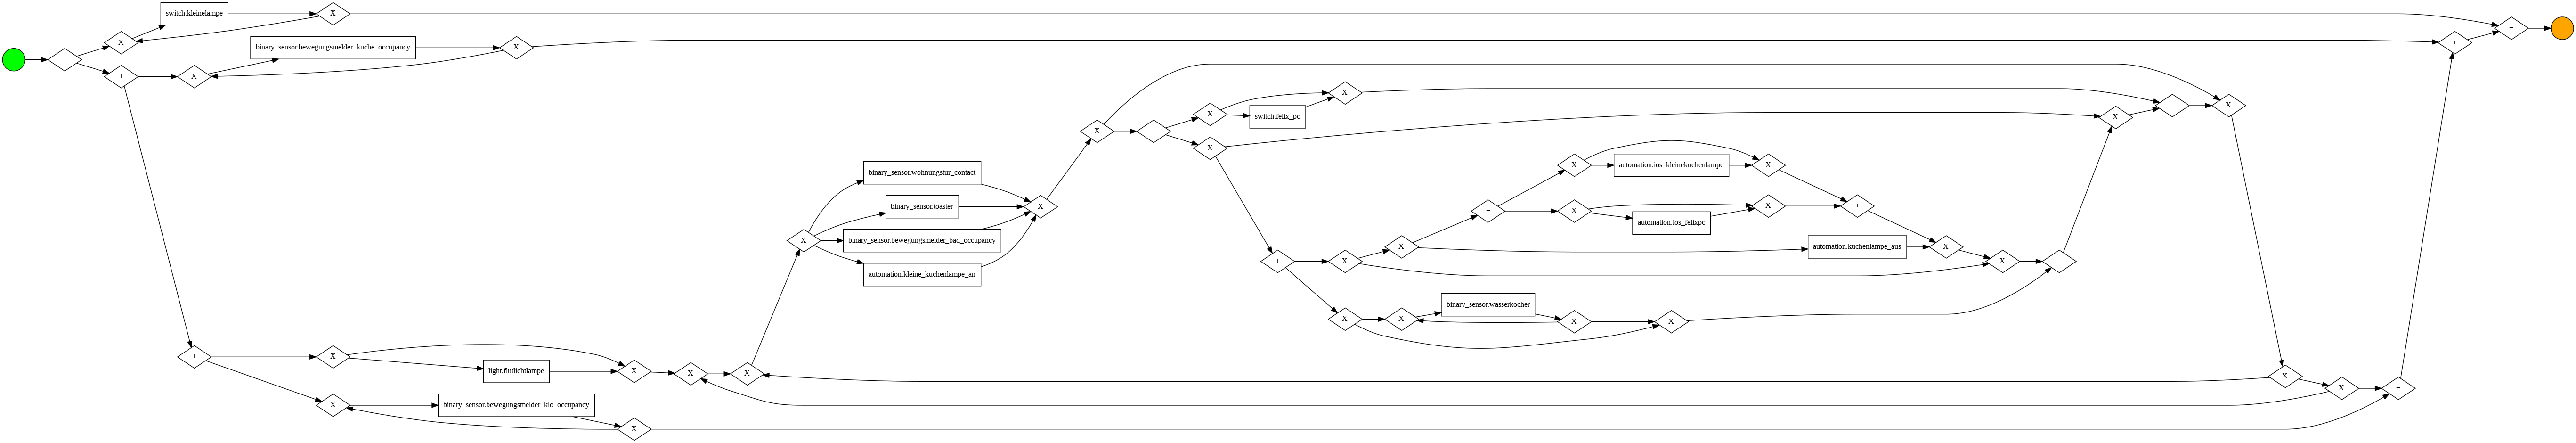

In [ ]:
bpmn_graph = pm4py.discover_bpmn_inductive(mining_data)
pm4py.vis.view_bpmn(bpmn_graph)

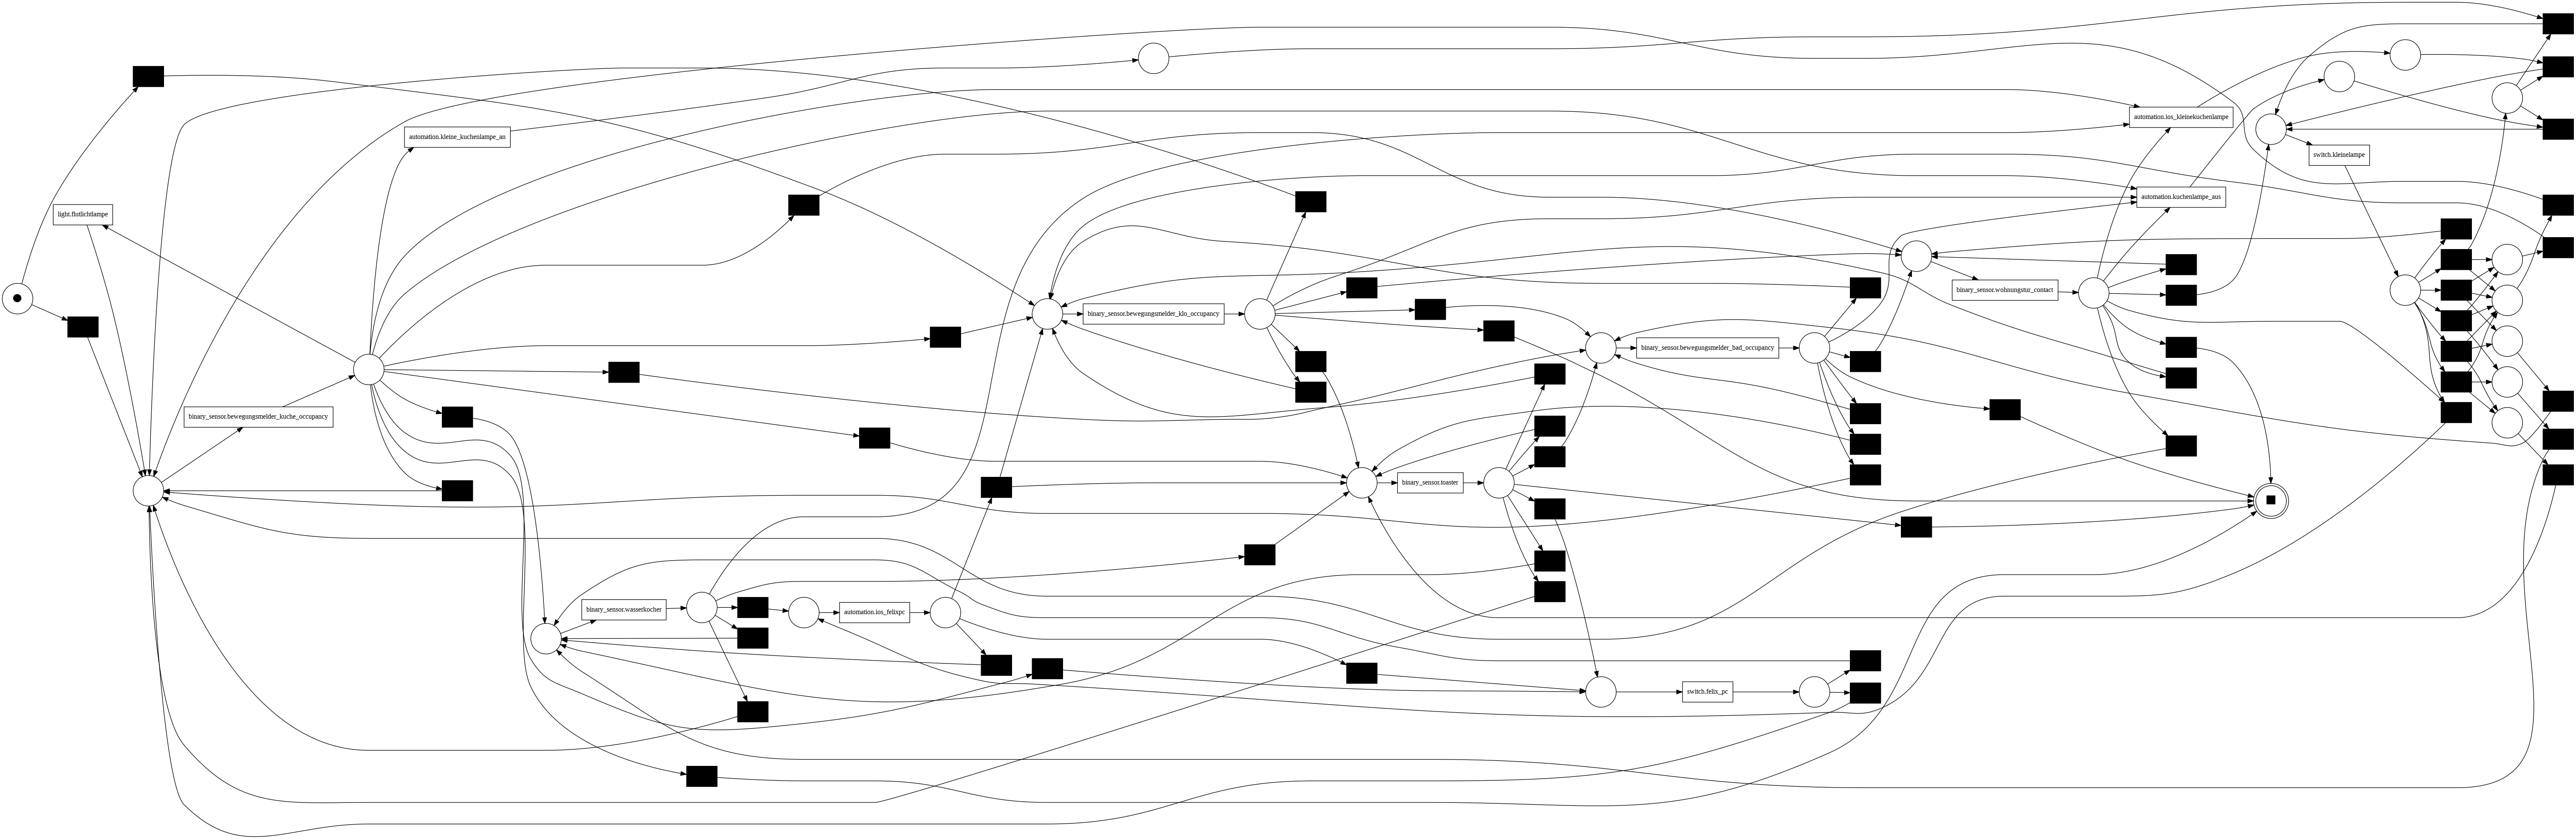

In [ ]:
dfg, sa, ea = pm4py.discover_petri_net_heuristics(mining_data)
pm4py.vis.view_petri_net(dfg, sa, ea)

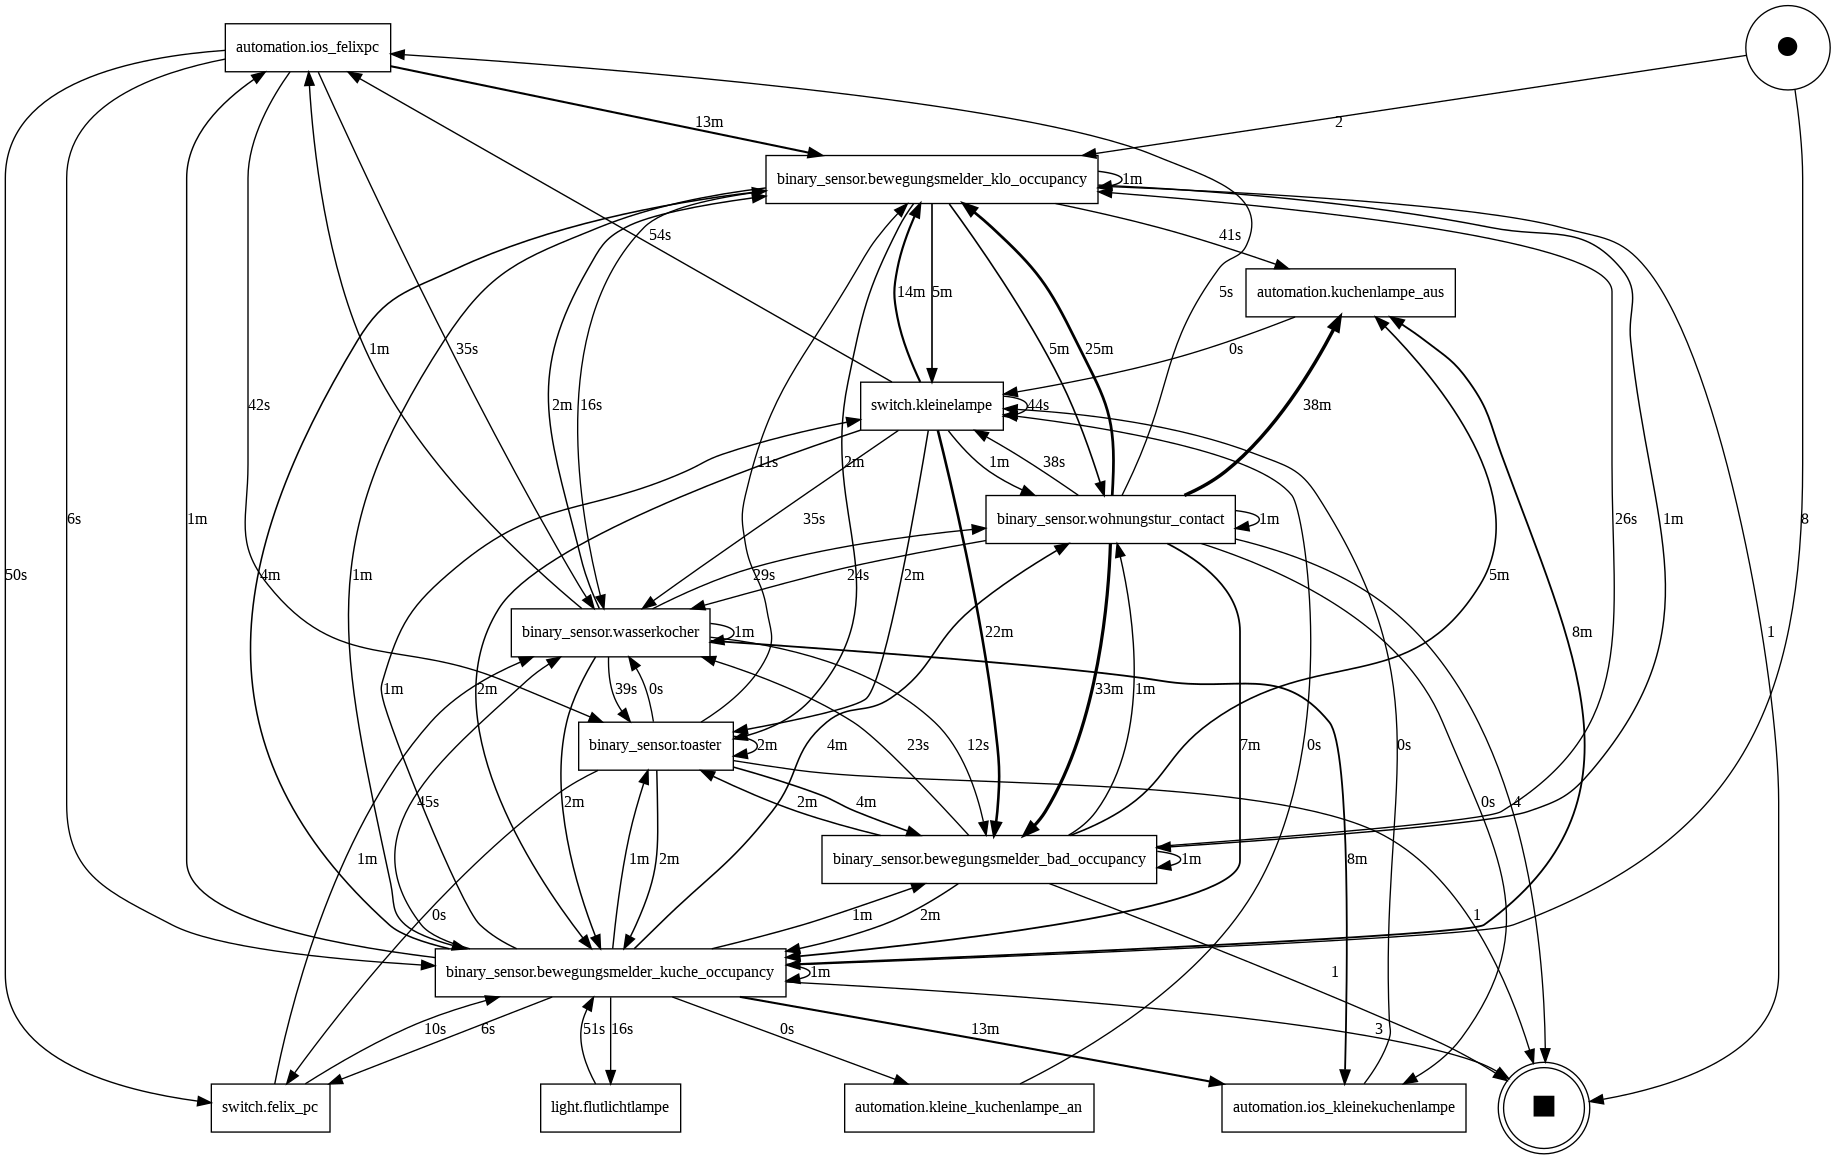

In [ ]:
dfg, sa, ea = pm4py.discover_performance_dfg(mining_data)
pm4py.vis.view_performance_dfg(dfg, sa, ea)

In [ ]:
#mining_data.to_csv("two_week_morning_filter.csv", index=False)